Term: YAI 2021 summer session

Team Member: Dongha Kim, Jeongeun Lee, Junho Lee, Suyeong Choi.

# Initialize and download

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time
from typing import Type
from IPython.display import Image

from extensions.easyrun import runtime_info  # type: ignore

device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(777)  # includes cuda.manual_seed_all

mnist_train: MNIST = MNIST(
    root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test: MNIST = MNIST(
    root='MNIST_data/', train=False, transform=ToTensor(), download=True)

print(runtime_info())

OS version: 		macOS-11.4-arm64-arm-64bit
Python version:		3.8.10 | packaged by conda-forge
Torch version:		1.8.0
Torch device:		cpu


# Implement Activation Layers

Activation layer skeleton
---

In [2]:
class Activation(torch.nn.Module):
    """Baseclass of activation layer: will be used in training."""

    available: tuple = ()

    def __new__(cls) -> ...:
        if cls is Activation:
            raise TypeError('Cannot make instance of abstract class.')
        return object.__new__(cls)

    def __init_subclass__(cls, *, register: bool = True, **kwargs) -> None:
        if register:
            Activation.available = (*Activation.available, cls)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

## ReLU

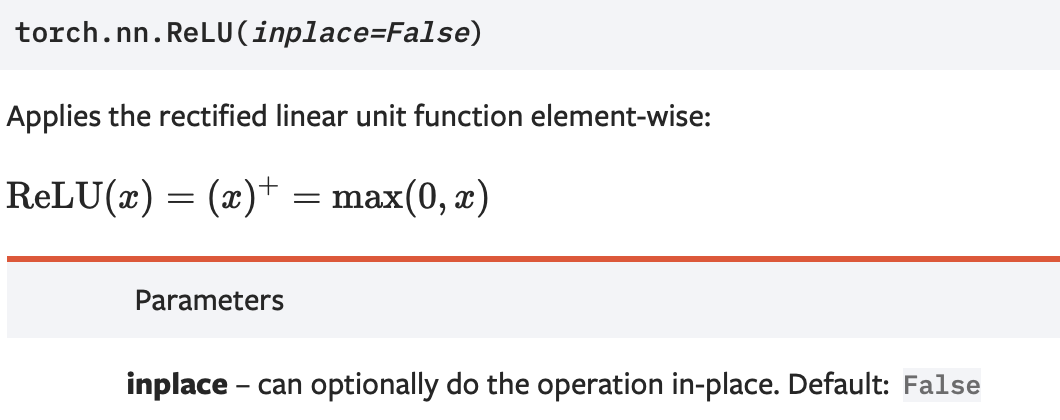

In [3]:
class ReLU(Activation, register=True):
    """ReLU Activation Layer: max(0, x)"""

    def __init__(self) -> None:
        Activation.__init__(self)
        # Buffer: model's non-grad tensor
        #   - moved between devices by module.to(device)
        self.register_buffer('zero_tensor', None)
        self.zero_tensor: torch.Tensor = torch.empty(1).fill_(0.)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.maximum(x, self.zero_tensor)

Image('img/relu.png')

## Sigmoid

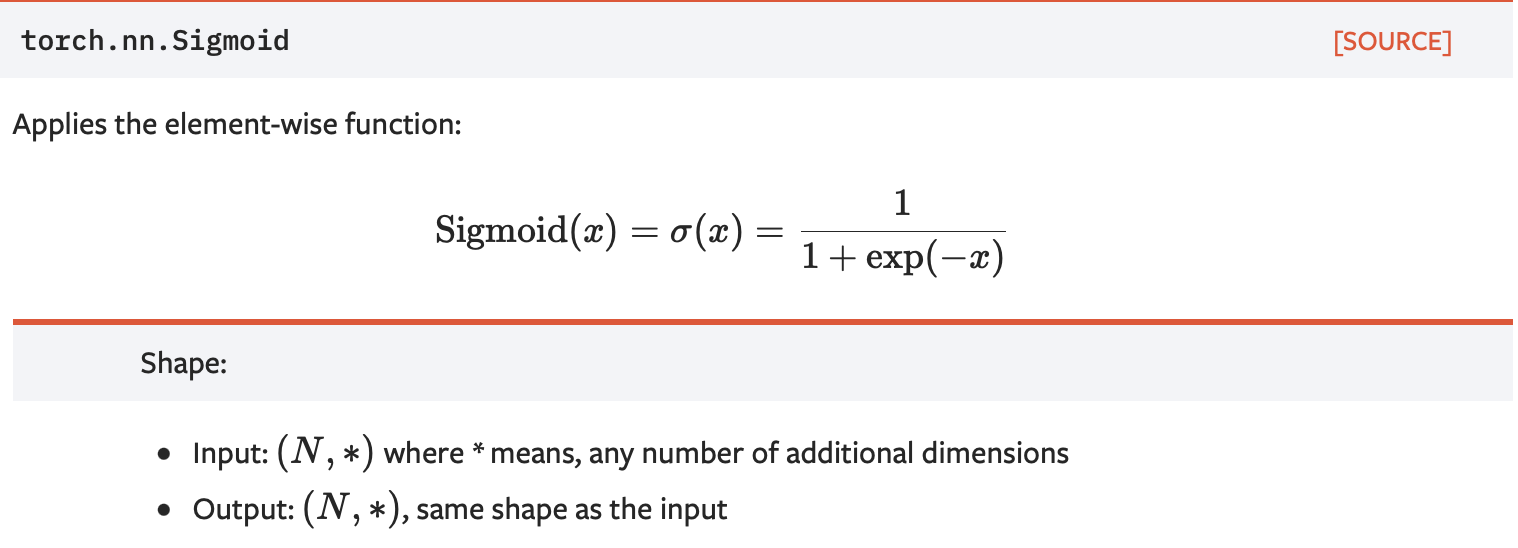

In [4]:
class Sigmoid(Activation, register=True):
    """Sigmoid Activation Layer: 1 / (1 + exp(-x))"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.div(1., torch.add(1., torch.exp(torch.negative(x))))

Image('img/sigmoid.png')

## Leaky ReLU

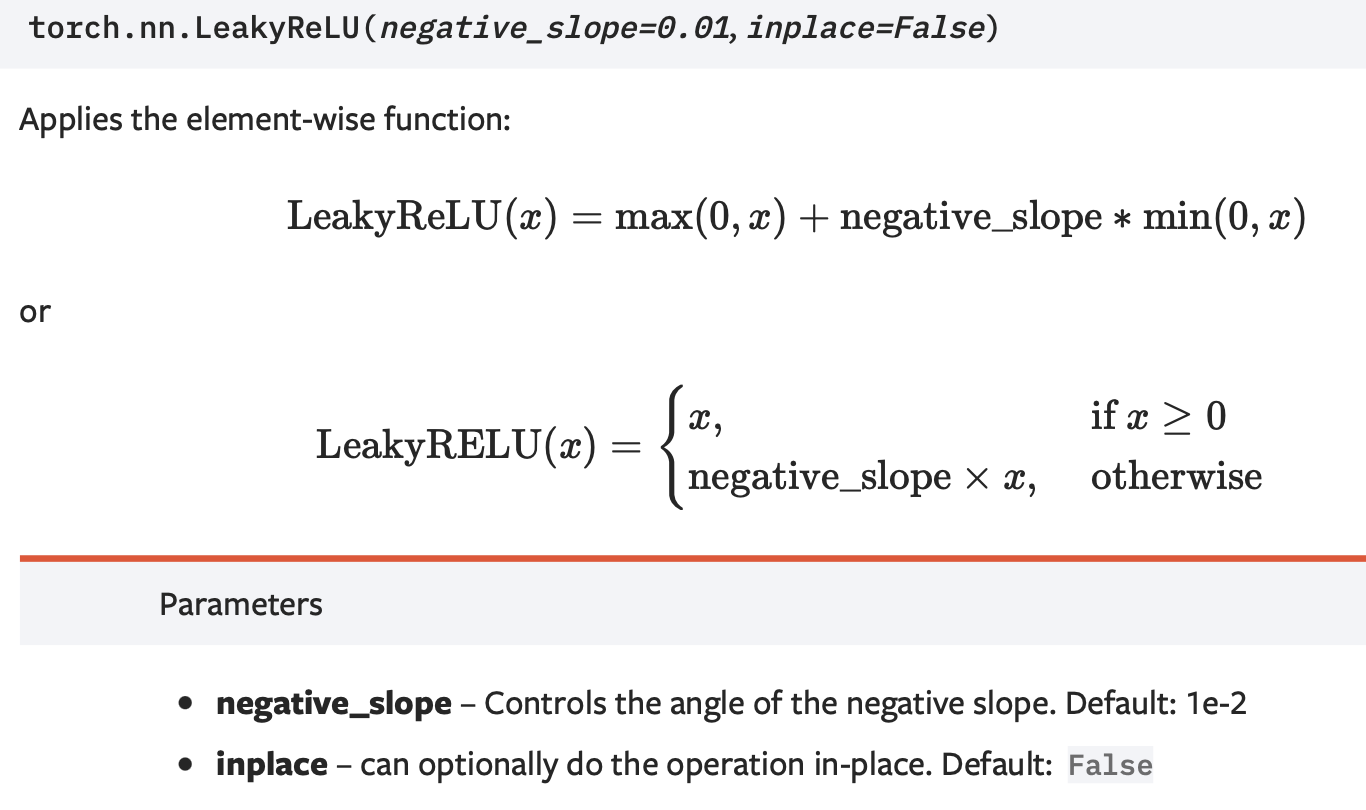

In [5]:
class LeakyReLU(Activation, register=True):
    """LeakyReLU Activation Layer: max(0, x) + negative_slope * min(0, x)"""

    def __init__(self, negative_slope: float = .01) -> None:
        Activation.__init__(self)
        self.negative_slope: float = negative_slope

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.where(
            torch.ge(x, 0.), x,
            torch.mul(x, self.negative_slope)
        )

Image('img/leaky_relu.png')

## PReLU

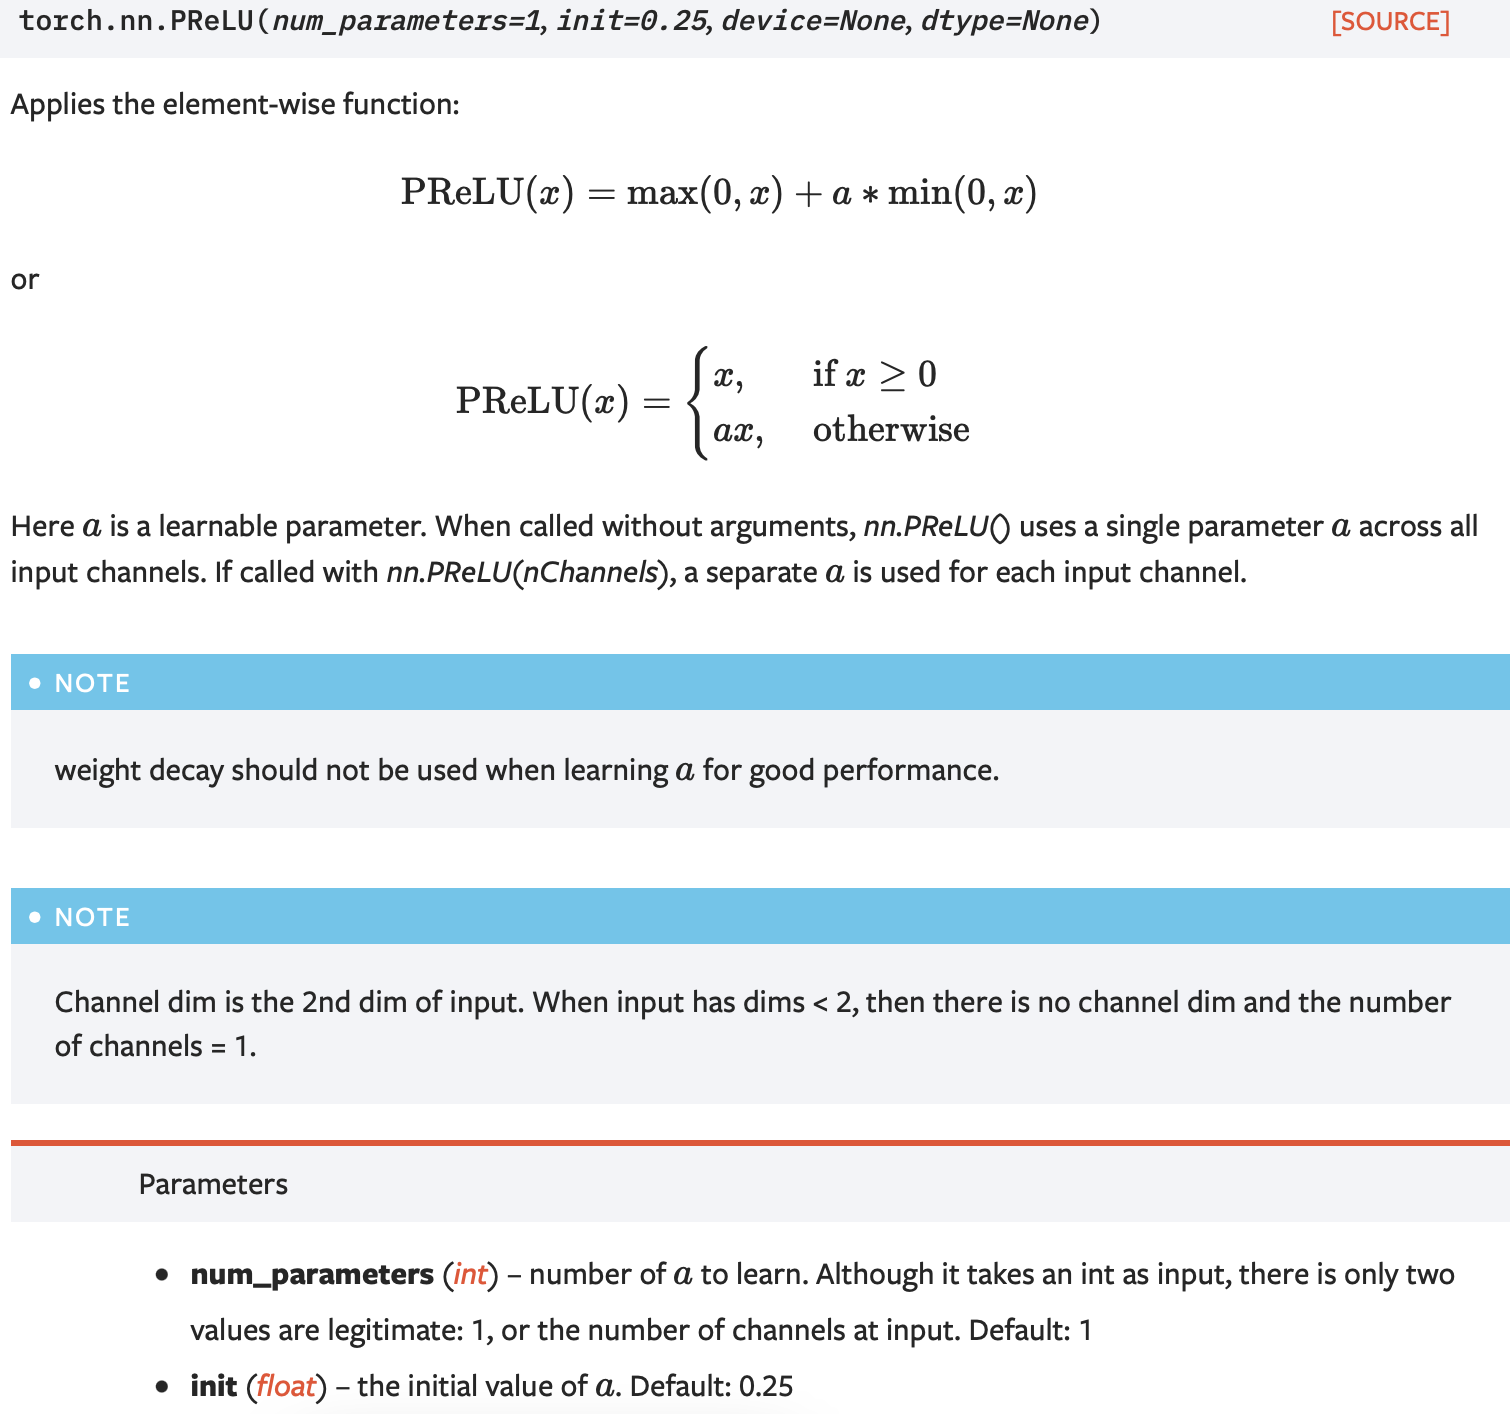

In [6]:
class PReLU(Activation, register=True):
    """PReLU Activation Layer: max(0, x) + alpha * min(0, x)"""

    def __init__(self, num_parameters: int = 1, init: float = .25) -> None:
        Activation.__init__(self)
        self.num_parameters: int = num_parameters
        # Parameter: model's grad tensor - registered to module.parameters(),
        #   moved between devices by module.to(device)
        self.alpha: torch.nn.Parameter = \
            torch.nn.Parameter(torch.empty(num_parameters).fill_(init))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.where(
            torch.ge(x, 0.), x,
            torch.mul(x, self.alpha)
        )

Image('img/prelu.png')

## ELU

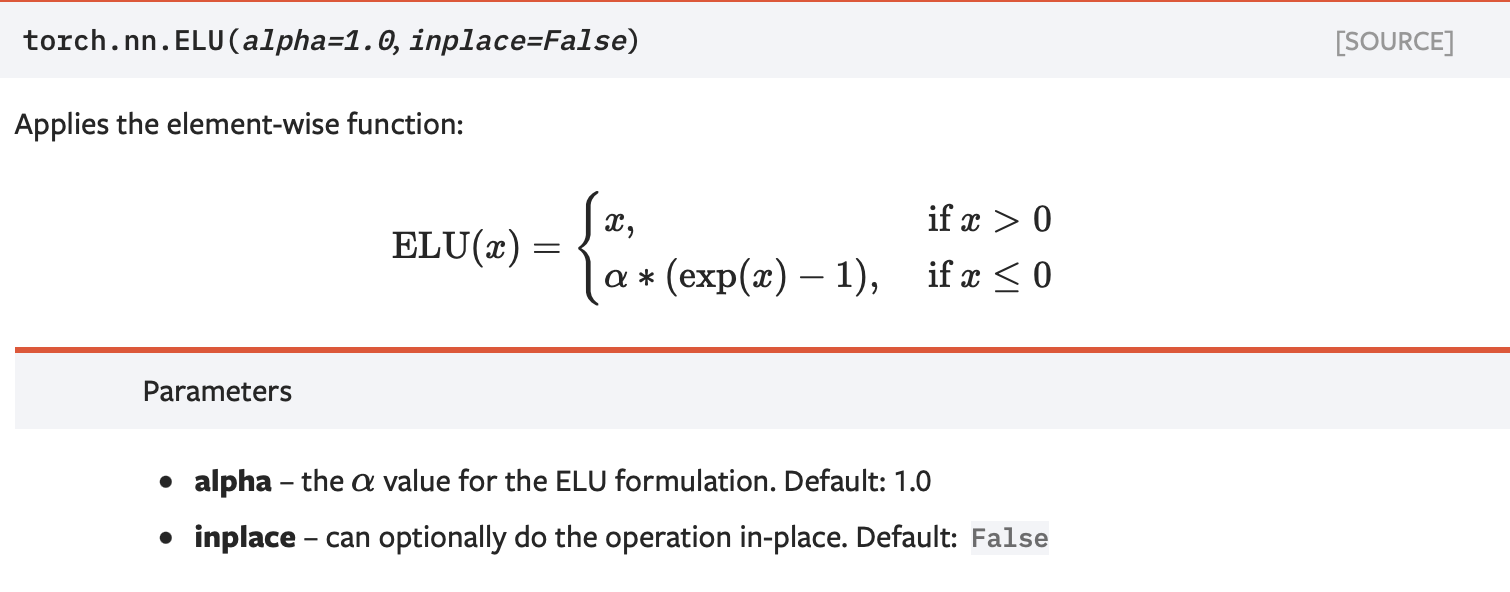

In [7]:
class ELU(Activation, register=True):
    """PReLU Activation Layer: max(0, x) + alpha * min(0, x)"""

    def __init__(self, alpha: float = 1.) -> None:
        Activation.__init__(self)
        self.alpha = alpha
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.where(
            torch.ge(x, 0.), x,
            torch.mul(torch.sub(torch.exp(x), 1.), self.alpha)
        )

Image('img/elu.png')

## SiLU

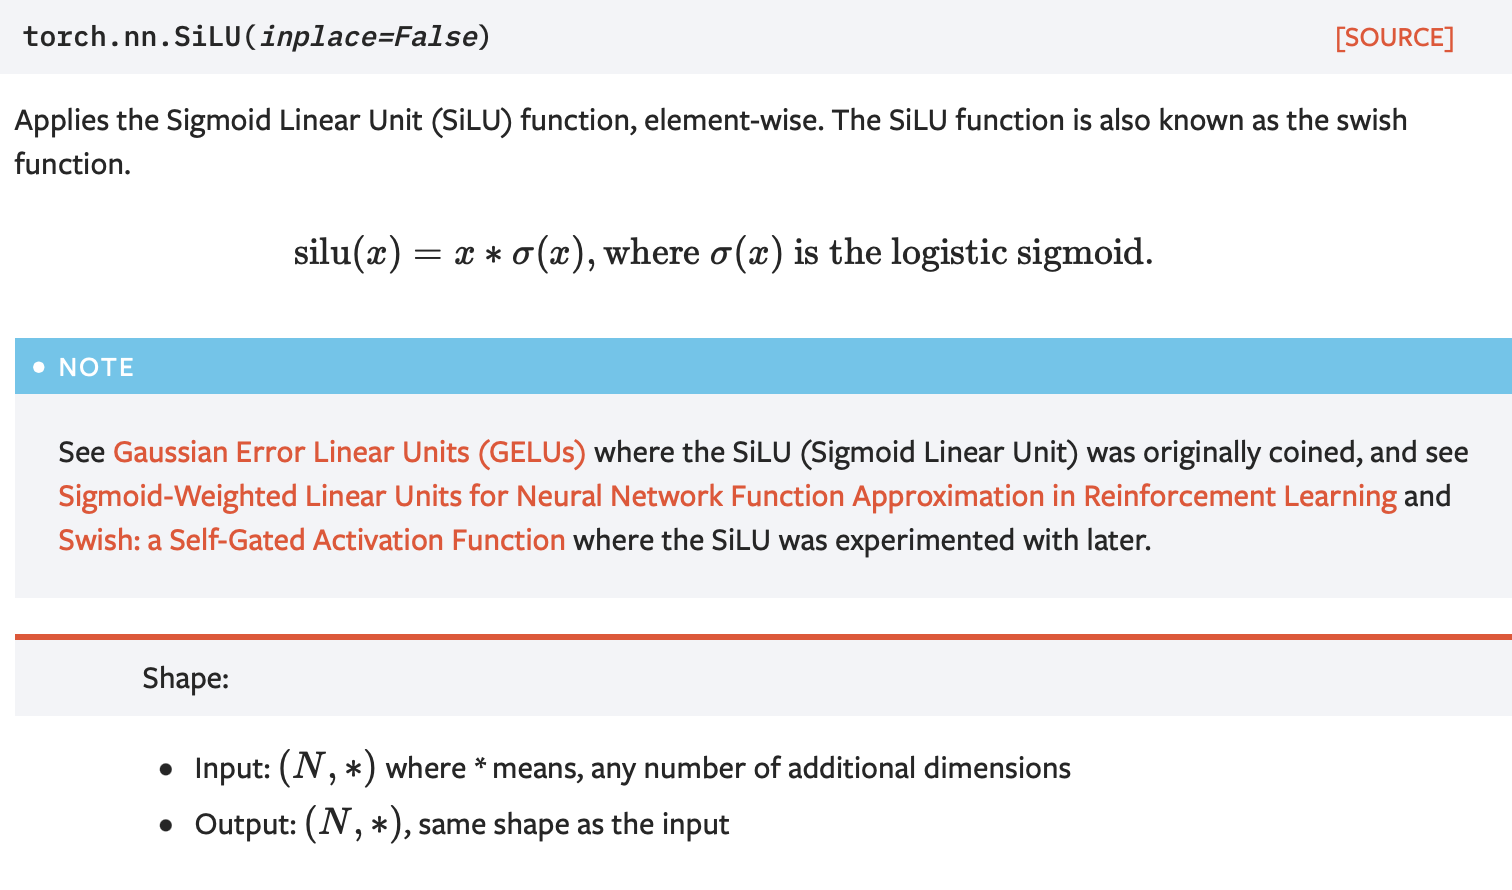

In [8]:
class SiLU(Activation, register=True):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.mul(x, torch.div(1., torch.add(1., torch.exp(torch.negative(x)))))

Image('img/silu.png')

## My Activation Layer

In [9]:
class MyActivation(Activation, register=True):

    def __init__(self, alpha: float = 1.) -> None:
        Activation.__init__(self)
        self.alpha: torch.nn.Parameter = torch.nn.Parameter(torch.empty(1).fill_(alpha))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.where(
            torch.ge(x, 0.),
            torch.mul(torch.tanh(x), self.alpha),
            torch.sub(torch.exp(x), 1.),
        )

$$ MyActivation(x)=\begin{cases}\alpha*tanh(x),\;if\;x\geq0\\exp(x)-1,\;if\;x\lt0\end{cases} $$

Here alpha is learnable parameter.

# Evaluate performance

## Prepare Net and Function

In [10]:
class Net(torch.nn.Module):

    def __init__(self, activation: Type[Activation]) -> None:
        # input image shape: width 28 * height 28 pixels
        # num_classes: 10 classes (0~9)
        super(Net, self).__init__()
        self.fc1: torch.nn.Module = torch.nn.Linear(28 * 28, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 10)
        self.activation = activation()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = x.view(-1, 784)
        y = self.activation(self.fc1(y))
        y = self.activation(self.fc2(y))
        y = self.activation(self.fc3(y))
        y = self.fc4(y)
        return y

In [11]:
def train_eval(
        activation: Type[Activation],
        learning_rate: float = 0.01,
        epochs: int = 10,
        batch_size: int = 1024,
) -> dict:

    data_loader = torch.utils.data.DataLoader(  # type: ignore
        dataset=mnist_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )

    total_batch = len(data_loader)  # iter per epoch = data size / batch size
    total_test = len(mnist_test)

    model = Net(activation).to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print('\n' + format(
        ' Using Activation Function: %s ' % activation.__name__.upper(),
        '#^80'
    ))
    test_acc_list = []; start = time.time()

    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_acc = 0

        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            acc = torch.eq(torch.argmax(prediction, 1), y).float().mean()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += acc.item()

        avg_loss = total_loss / total_batch
        avg_acc = total_acc / total_batch

        with torch.no_grad():
            x = mnist_test.data.view(total_test, 1, 28, 28).float().to(device)
            y = mnist_test.targets.to(device)

            test_prediction = model(x)
            correct_prediction = torch.eq(torch.argmax(test_prediction, 1), y)
            test_acc = correct_prediction.float().mean().item()
            test_acc_list.append(test_acc)

        print(
            f'[Epoch:{epoch:>2}] '
            f'train_loss:{avg_loss:.4f}, '
            f'train_acc:{avg_acc:.4f}, '
            f'test_acc:{test_acc:.4f}, '
            f'best_acc:{max(test_acc_list):.4f}'
        )

    end = time.time(); duration = end - start; best_acc = max(test_acc_list)
    result_dict = {'time': duration, 'accuracy' : best_acc}
    print(format(
        ' Time: %(time).2fs | Accuracy: %(accuracy).4fs ' % result_dict, 
        '#^80'
    ))
    return result_dict

## Run

In [12]:
performance_df = pd.DataFrame({cls.__name__: train_eval(cls) for cls in Activation.available}).T  # 한줄러닝


####################### Using Activation Function: RELU ########################
[Epoch: 1] train_loss:0.8591, train_acc:0.7177, test_acc:0.9031, best_acc:0.9031
[Epoch: 2] train_loss:0.2561, train_acc:0.9266, test_acc:0.9433, best_acc:0.9433
[Epoch: 3] train_loss:0.1718, train_acc:0.9503, test_acc:0.9543, best_acc:0.9543
[Epoch: 4] train_loss:0.1399, train_acc:0.9589, test_acc:0.9492, best_acc:0.9543
[Epoch: 5] train_loss:0.1161, train_acc:0.9654, test_acc:0.9558, best_acc:0.9558
[Epoch: 6] train_loss:0.1001, train_acc:0.9695, test_acc:0.9650, best_acc:0.9650
[Epoch: 7] train_loss:0.0835, train_acc:0.9743, test_acc:0.9640, best_acc:0.9650
[Epoch: 8] train_loss:0.0759, train_acc:0.9765, test_acc:0.9699, best_acc:0.9699
[Epoch: 9] train_loss:0.0692, train_acc:0.9779, test_acc:0.9639, best_acc:0.9699
[Epoch:10] train_loss:0.0632, train_acc:0.9796, test_acc:0.9663, best_acc:0.9699
####################### Time: 16.53s | Accuracy: 0.9699s #######################

###################### Usi

## Evaluate

In [13]:
performance_df

,time,accuracy
ReLU,16.525383,0.9699
Sigmoid,16.656063,0.9537
LeakyReLU,15.962956,0.9707
PReLU,16.330933,0.9701
ELU,16.841871,0.9401
SiLU,17.904983,0.9716
MyActivation,17.291569,0.9593


Best Accuracy Activation Function was: 0.9716, SiLU
Custom Activation Function Accuracy Rank: 5
Custom Activation Function Time Complexity Rank: 6


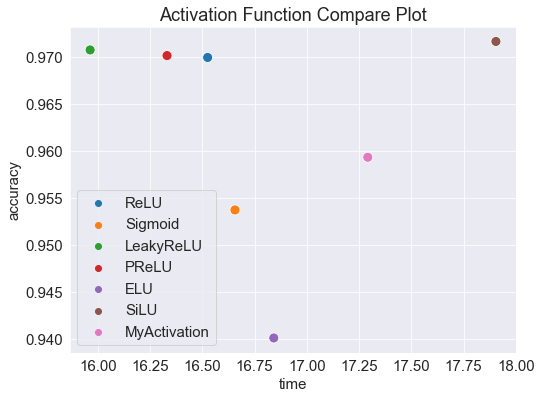

In [14]:
print(f"Best Accuracy Activation Function was: {performance_df['accuracy'].max():.4f}, {performance_df.index[performance_df['accuracy'].argmax()]}")
print(f"Custom Activation Function Accuracy Rank: {int(performance_df['accuracy'].rank(method='max', ascending=False)[MyActivation.__name__])}")
print(f"Custom Activation Function Time Complexity Rank: {int(performance_df['time'].rank(method='min')[MyActivation.__name__])}")

plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 15})
plt.title("Activation Function Compare Plot")
sns.scatterplot(data=performance_df, x='time', y='accuracy', hue=performance_df.index, s=100)
plt.show()